In [2]:
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 42.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [3]:
!pip install fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=d75514542b9cf2ce199ebe7f13dce5f9a5db93410552ad2428f9ae24937df559
  Stored in directory: /root/.cache/pip/wheels/65/71/95/3b8fde5c65c6e4a806e0867c1651dcc71a1cb2f3430e8f355f
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=172bc08d35fc5c15bf6c58735653208af86582f920bcd34eec8ebc816534045a
  Stored in directory: /root/.cache/pip/wheels/ba/5e/16/6117f8fe7e9c0c161a795e10d94645ebcf301ccbd01f66d8ec
Successfully built fvcore iopath


In [ ]:
import os
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import time
from torch.utils.data import DataLoader, Dataset, random_split
from torchaudio.datasets import SPEECHCOMMANDS
from fvcore.nn import FlopCountAnalysis

In [ ]:
class SubsetSCFiltered(Dataset):
    def __init__(self, dataset):
        self.dataset = [d for d in dataset if d[2] in ["yes", "no"]]

    def __getitem__(self, index):
        waveform, sample_rate, label, *_ = self.dataset[index]
        label_id = 1 if label == "yes" else 0
        return waveform, label_id

    def __len__(self):
        return len(self.dataset)

In [ ]:
def pad_or_trim_waveform(waveform, target_len=16000):
    current_len = waveform.shape[1]
    if current_len > target_len:
        return waveform[:, :target_len]
    elif current_len < target_len:
        pad = torch.zeros((1, target_len - current_len))
        return torch.cat([waveform, pad], dim=1)
    return waveform

def collate_fn(batch):
    waveforms, labels = zip(*batch)
    waveforms = [pad_or_trim_waveform(w) for w in waveforms]
    waveforms = torch.stack(waveforms)
    labels = torch.tensor(labels)
    return waveforms, labels


In [ ]:
class LogMelFilterBanks(nn.Module):
    def __init__(self, n_fft=400, hop_length=160, n_mels=80, sample_rate=16000):
        super().__init__()
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.sample_rate = sample_rate
        self.fbanks = None

    def _init_melscale_fbanks(self, num_freqs):
        return torchaudio.functional.melscale_fbanks(
            n_freqs=num_freqs,
            n_mels=self.n_mels,
            sample_rate=self.sample_rate,
            f_min=0.0,
            f_max=self.sample_rate / 2,
            norm="slaney",
            mel_scale="htk"
        )

    def spectrogram(self, x):
        x = x.squeeze(1)
        window = torch.hann_window(self.n_fft, device=x.device)
        stft = torch.stft(x, n_fft=self.n_fft, hop_length=self.hop_length,
                          win_length=self.n_fft, window=window, return_complex=True)
        return torch.abs(stft) ** 2

    def forward(self, x):
        power_spec = self.spectrogram(x)
        num_freqs = power_spec.shape[-1]
        if self.fbanks is None or self.fbanks.shape[0] != num_freqs:
            self.fbanks = self._init_melscale_fbanks(num_freqs).to(x.device)
        mel_spec = torch.matmul(power_spec, self.fbanks)
        return torch.log(mel_spec + 1e-6)


In [ ]:
class SpeechCNN(pl.LightningModule):
    def __init__(self, n_mels=80, groups=1):
        super().__init__()
        self.save_hyperparameters()
        self.logmel = LogMelFilterBanks(n_mels=n_mels)
        self.conv1 = nn.Conv1d(n_mels, 64, kernel_size=5, stride=1, groups=groups)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, stride=1, groups=groups)
        self._compute_fc_input()
        self.fc1 = nn.Linear(self.fc_input_features, 256)
        self.fc2 = nn.Linear(256, 2)

    def _compute_fc_input(self):
        with torch.no_grad():
            dummy = torch.randn(1, 1, 16000)
            x = self.logmel(dummy)
            x = x.transpose(1, 2)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            self.fc_input_features = x.shape[1] * x.shape[2]

    def forward(self, x):
        x = self.logmel(x)  # [B, T, M]
        x = x.transpose(1, 2)  # [B, M, T]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(1) == y).float().mean()
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(1) == y).float().mean()
        self.log("val_loss", loss)
        self.log("val_acc", acc)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        acc = (logits.argmax(1) == y).float().mean()
        self.log("test_acc", acc)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def compute_flops(self):
        dummy = torch.randn(1, 1, 16000)
        flops = FlopCountAnalysis(self, dummy)
        return flops.total()


In [ ]:
def train_model(n_mels=40, groups=1):
    if n_mels % groups != 0:
        raise ValueError(f"n_mels ({n_mels}) must be divisible by groups ({groups})")

    lengths = [int(0.8 * len(filtered_dataset)), int(0.1 * len(filtered_dataset))]
    lengths.append(len(filtered_dataset) - sum(lengths))
    train_set, val_set, test_set = random_split(filtered_dataset, lengths, generator=torch.Generator().manual_seed(42))

    train_loader = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_set, batch_size=32, collate_fn=collate_fn)
    test_loader = DataLoader(test_set, batch_size=32, collate_fn=collate_fn)

    model = SpeechCNN(n_mels=n_mels, groups=groups)
    trainer = pl.Trainer(max_epochs=10, log_every_n_steps=10)
    trainer.fit(model, train_loader, val_loader)
    trainer.test(model, test_loader)

    return model

In [ ]:
def plot_experiment_results(results):
    import pandas as pd
    df = pd.DataFrame(results, columns=["n_mels", "groups", "acc", "train_time", "params", "flops"])

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    for n_mels in sorted(df["n_mels"].unique()):
        sub = df[df["n_mels"] == n_mels]
        plt.plot(sub["groups"], sub["acc"], marker="o", label=f"n_mels={n_mels}")
    plt.title("Test Accuracy vs Groups")
    plt.xlabel("Groups")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 3, 2)
    for n_mels in sorted(df["n_mels"].unique()):
        sub = df[df["n_mels"] == n_mels]
        plt.plot(sub["groups"], sub["params"], marker="x", label=f"n_mels={n_mels}")
    plt.title("Params vs Groups")
    plt.xlabel("Groups")
    plt.ylabel("Parameters")
    plt.legend()

    plt.subplot(1, 3, 3)
    for n_mels in sorted(df["n_mels"].unique()):
        sub = df[df["n_mels"] == n_mels]
        plt.plot(sub["groups"], sub["train_time"], marker="s", label=f"n_mels={n_mels}")
    plt.title("Training Time vs Groups")
    plt.xlabel("Groups")
    plt.ylabel("Train Time (s)")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def run_experiments():
    n_mels_list = [20, 40, 80]
    groups_list = [1, 2, 4, 8]
    results = []

    for n_mels in n_mels_list:
        accs = []
        for groups in groups_list:
            if n_mels % groups != 0:
                continue
            start = time.time()
            model = train_model(n_mels=n_mels, groups=groups)
            end = time.time()
            acc = float(model.trainer.callback_metrics["test_acc"])
            params = model.count_parameters()
            flops = model.compute_flops()
            results.append((n_mels, groups, acc, end - start, params, flops))
            print(f"n_mels={n_mels}, groups={groups} -> acc={acc:.3f}, time={end-start:.1f}s")

    plot_experiment_results(results)

In [ ]:
base = SPEECHCOMMANDS("./", download=True)
filtered_dataset = SubsetSCFiltered(base)

100%|██████████| 2.26G/2.26G [01:17<00:00, 31.2MB/s]
INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type              | Params | Mode 
-----------------------------------------------------
0 | logmel | LogMelFilterBanks | 0      | train
1 | conv1  | Conv1d            | 6.5 K  | train
2 | conv2  | Conv1d            | 41.1 K | train
3 | fc1    | Linear            | 6.3 M  | train
4 | fc2    | Linear            | 514    | train
-----------------------------------------------------
6.4 M     Trainable params
0         Non-trainable params
6.4 M     Total params
25.490

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9687108993530273     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type              | Params | Mode 
-----------------------------------------------------
0 | logmel | LogMelFilterBanks | 0      | train
1 | conv1  | Conv1d            | 3.3 K  | train
2 | conv2  | Conv1d            | 20.6 K | train
3 | fc1    | Linear            | 6.3 M  | train
4 | fc2    | Linear            | 514    | train
-----------------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.395    Total estimated model params size (MB)
5         

n_mels=20, groups=1 -> acc=0.969, time=251.8s


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9374217987060547     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type              | Params | Mode 
-----------------------------------------------------
0 | logmel | LogMelFilterBanks | 0      | train
1 | conv1  | Conv1d            | 1.7 K  | train
2 | conv2  | Conv1d            | 10.4 K | train
3 | fc1    | Linear            | 6.3 M  | train
4 | fc2    | Linear            | 514    | train
-----------------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.348    Total estimated model params size (MB)
5         

n_mels=20, groups=2 -> acc=0.937, time=215.7s


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9737171530723572     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type              | Params | Mode 
-----------------------------------------------------
0 | logmel | LogMelFilterBanks | 0      | train
1 | conv1  | Conv1d            | 12.9 K | train
2 | conv2  | Conv1d            | 41.1 K | train
3 | fc1    | Linear            | 6.3 M  | train
4 | fc2    | Linear            | 514    | train
-----------------------------------------------------
6.4 M     Trainable params
0         Non-trainable params
6.4 M     Total params
25.516    Total estimated model params size (MB)
5         

n_mels=20, groups=4 -> acc=0.974, time=221.5s


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9586983919143677     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type              | Params | Mode 
-----------------------------------------------------
0 | logmel | LogMelFilterBanks | 0      | train
1 | conv1  | Conv1d            | 6.5 K  | train
2 | conv2  | Conv1d            | 20.6 K | train
3 | fc1    | Linear            | 6.3 M  | train
4 | fc2    | Linear            | 514    | train
-----------------------------------------------------
6.4 M     Trainable params
0         Non-trainable params
6.4 M     Total params
25.408    Total estimated model params size (MB)
5         

n_mels=40, groups=1 -> acc=0.959, time=256.7s


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9649562239646912     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type              | Params | Mode 
-----------------------------------------------------
0 | logmel | LogMelFilterBanks | 0      | train
1 | conv1  | Conv1d            | 3.3 K  | train
2 | conv2  | Conv1d            | 10.4 K | train
3 | fc1    | Linear            | 6.3 M  | train
4 | fc2    | Linear            | 514    | train
-----------------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.355    Total estimated model params size (MB)
5         

n_mels=40, groups=2 -> acc=0.965, time=233.0s


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9712139964103699     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type              | Params | Mode 
-----------------------------------------------------
0 | logmel | LogMelFilterBanks | 0      | train
1 | conv1  | Conv1d            | 1.7 K  | train
2 | conv2  | Conv1d            | 5.2 K  | train
3 | fc1    | Linear            | 6.3 M  | train
4 | fc2    | Linear            | 514    | train
-----------------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.328    Total estimated model params size (MB)
5         

n_mels=40, groups=4 -> acc=0.971, time=230.9s


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9724655747413635     │
└───────────────────────────┴───────────────────────────┘

/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (80) may be set too high. Or, the value for `n_freqs` (101) may be set too low.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type              | Params | Mode 
-----------------------------------------------------
0 | logmel | LogMelFilterBanks | 0      | train
1 | conv1  | Conv1d            | 25.7 K | train
2 | conv2  | Conv1d            | 41.1 K | train
3 | fc1    | Linear        

n_mels=40, groups=8 -> acc=0.972, time=221.4s


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9436795711517334     │
└───────────────────────────┴───────────────────────────┘

/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (80) may be set too high. Or, the value for `n_freqs` (101) may be set too low.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type              | Params | Mode 
-----------------------------------------------------
0 | logmel | LogMelFilterBanks | 0      | train
1 | conv1  | Conv1d            | 12.9 K | train
2 | conv2  | Conv1d            | 20.6 K | train
3 | fc1    | Linear        

n_mels=80, groups=1 -> acc=0.944, time=278.3s


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9674593210220337     │
└───────────────────────────┴───────────────────────────┘

/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (80) may be set too high. Or, the value for `n_freqs` (101) may be set too low.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type              | Params | Mode 
-----------------------------------------------------
0 | logmel | LogMelFilterBanks | 0      | train
1 | conv1  | Conv1d            | 6.5 K  | train
2 | conv2  | Conv1d            | 10.4 K | train
3 | fc1    | Linear        

n_mels=80, groups=2 -> acc=0.967, time=246.7s


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9612014889717102     │
└───────────────────────────┴───────────────────────────┘

/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (80) may be set too high. Or, the value for `n_freqs` (101) may be set too low.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type              | Params | Mode 
-----------------------------------------------------
0 | logmel | LogMelFilterBanks | 0      | train
1 | conv1  | Conv1d            | 3.3 K  | train
2 | conv2  | Conv1d            | 5.2 K  | train
3 | fc1    | Linear        

n_mels=80, groups=4 -> acc=0.961, time=238.3s


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9637046456336975     │
└───────────────────────────┴───────────────────────────┘

n_mels=80, groups=8 -> acc=0.964, time=248.8s


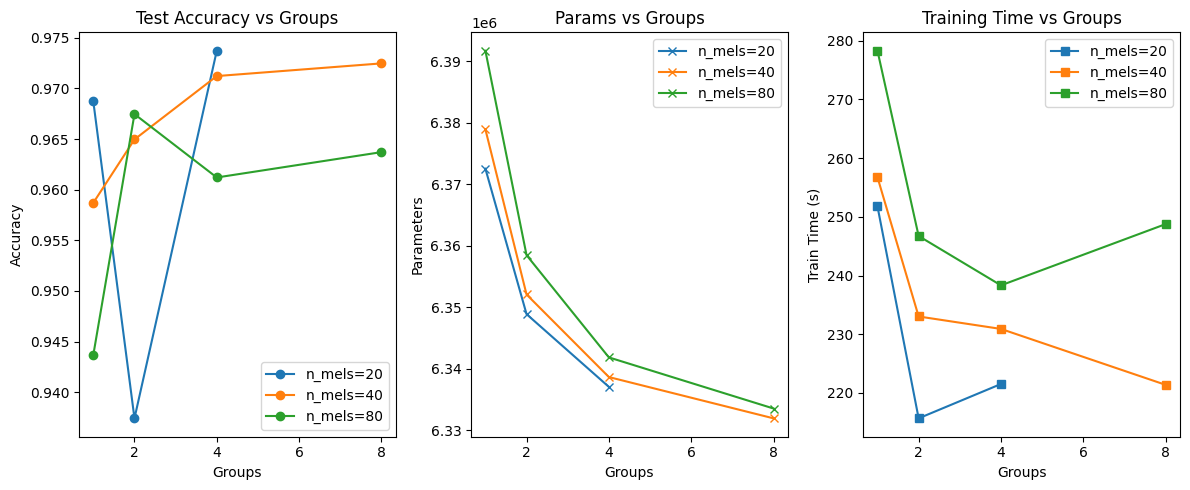

In [4]:
run_experiments()